# Dataset analysis

### Visualization of content

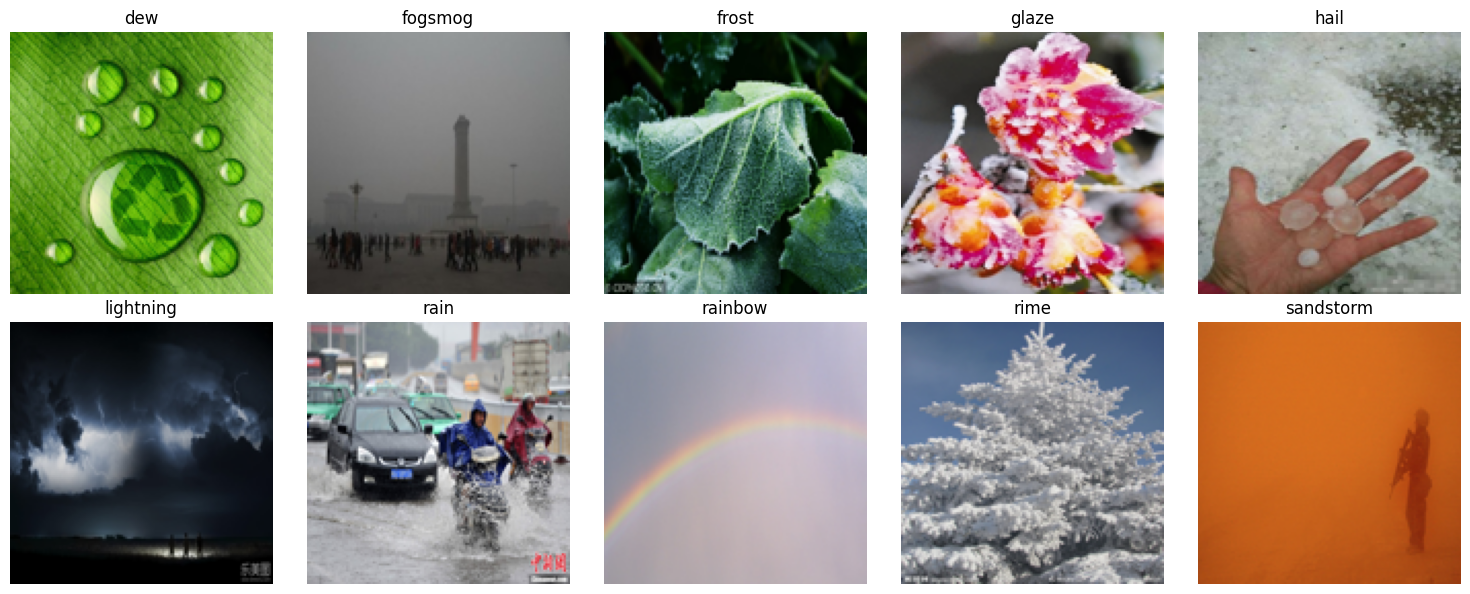

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

def show_examples_from_subfolders(folder_path, rows=2, cols=5, img_size=(128,128)):
    subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()]
    class_names = [os.path.basename(f) for f in subfolders]

    plt.figure(figsize=(15, 6))
    
    for i, (class_name, subfolder) in enumerate(zip(class_names, subfolders)):
        if i >= rows * cols:
            break
        
        files = [f for f in os.listdir(subfolder) if os.path.isfile(os.path.join(subfolder, f))]
        img_path = os.path.join(subfolder, random.choice(files))
        
        img = Image.open(img_path).convert("RGB")
        img = img.resize(img_size)

        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Uso
folder_path = "../dataset"
show_examples_from_subfolders(folder_path, rows=2, cols=5, img_size=(128,128))


### Class distribution

C:\Users\joaqu\AppData\Local\Temp\ipykernel_6464\361448619.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_total, x="Class", y="Count", ax=axes[0], palette=bar_colors)
C:\Users\joaqu\AppData\Local\Temp\ipykernel_6464\361448619.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_split, x="Class", y="Count", ax=axes[i], palette=bar_colors)
C:\Users\joaqu\AppData\Local\Temp\ipykernel_6464\361448619.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_split, x="Class", y="Count", ax=axes[i], palette=bar_colors)
C:\U

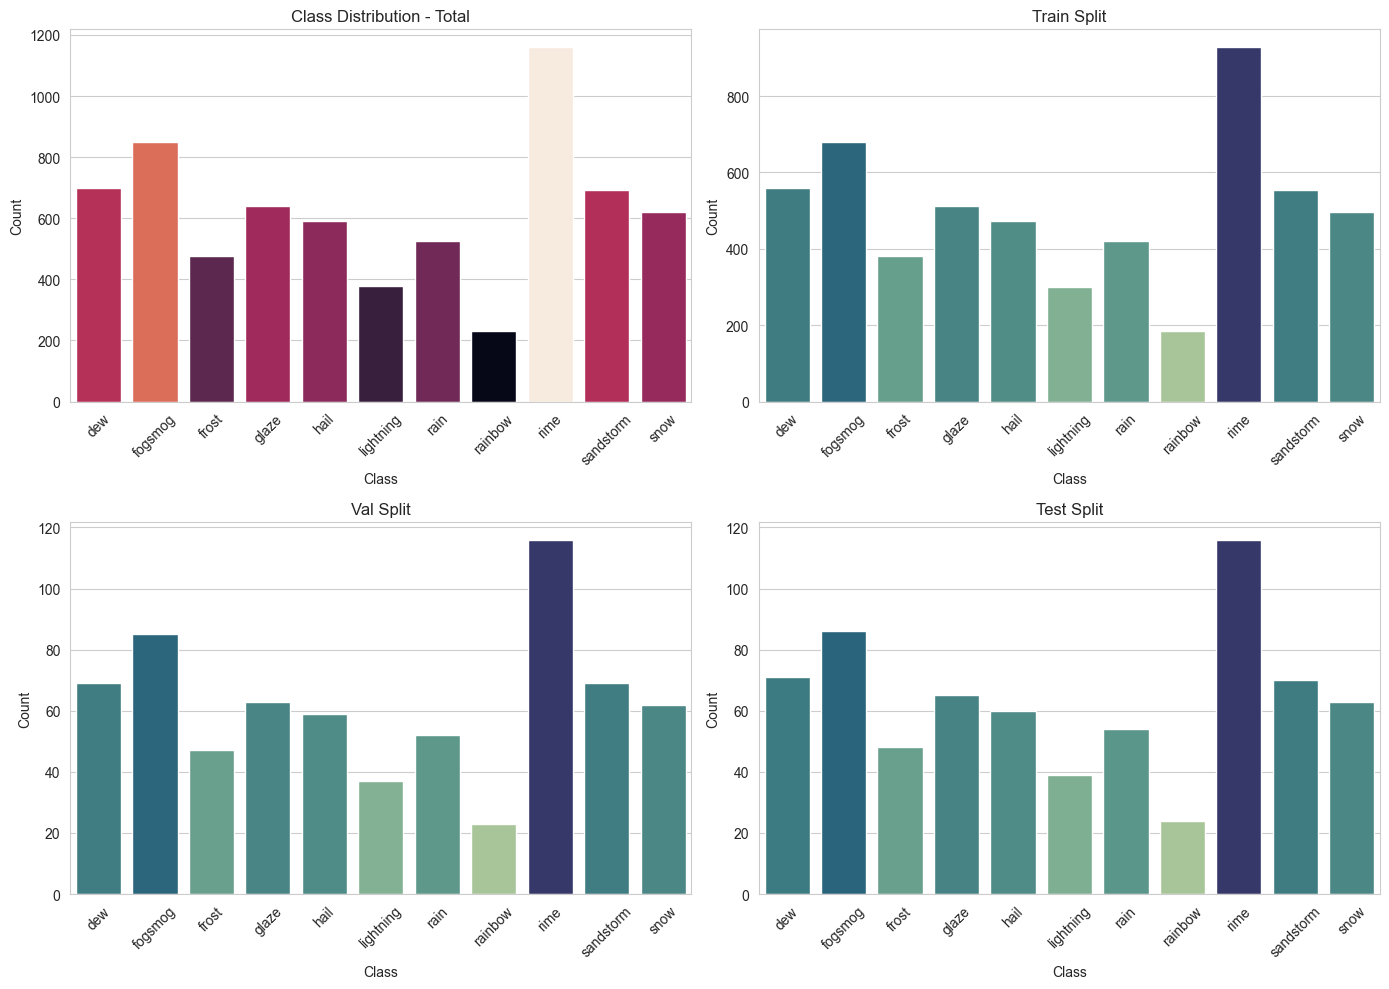

In [10]:
import os
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_style("whitegrid")

def count_classes_in_split(folder_path):
    counts = {}
    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            n_files = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
            counts[class_name] = n_files
    return counts

def plot_class_distribution_grid(dest_folder):
    splits = ['train', 'val', 'test']
    total_counts = Counter()

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.ravel()

    for split in splits:
        split_path = os.path.join(dest_folder, split)
        counts = count_classes_in_split(split_path)
        total_counts.update(counts)

    df_total = pd.DataFrame(list(total_counts.items()), columns=["Class", "Count"])
    colors = sns.color_palette("rocket", n_colors=len(df_total))
    norm = plt.Normalize(df_total["Count"].min(), df_total["Count"].max())
    sm = plt.cm.ScalarMappable(cmap="rocket", norm=norm)
    bar_colors = [sm.to_rgba(c) for c in df_total["Count"]]

    sns.barplot(data=df_total, x="Class", y="Count", ax=axes[0], palette=bar_colors)
    axes[0].set_title("Class Distribution - Total")
    axes[0].tick_params(axis='x', rotation=45)

    for i, split in enumerate(splits, start=1):
        split_path = os.path.join(dest_folder, split)
        counts = count_classes_in_split(split_path)
        df_split = pd.DataFrame(list(counts.items()), columns=["Class", "Count"])

        norm = plt.Normalize(df_split["Count"].min(), df_split["Count"].max())
        sm = plt.cm.ScalarMappable(cmap="crest", norm=norm)
        bar_colors = [sm.to_rgba(c) for c in df_split["Count"]]

        sns.barplot(data=df_split, x="Class", y="Count", ax=axes[i], palette=bar_colors)
        axes[i].set_title(f"{split.capitalize()} Split")
        axes[i].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

dest_folder = "../data"
plot_class_distribution_grid(dest_folder)


### Dimension overview

https://www.kaggle.com/code/faldoae/exploratory-data-analysis-eda-for-image-datasets

### Color analysis / Mean image